In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json

In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = np.max(samples_distances)

            colors = k3d.helpers.map_colors(
                samples_distances, k3d.colormaps.basic_color_maps.WarmCool, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            directions_to_plot = np.hstack((samples, samples + directions))
            
            for i, dir_to_plot in enumerate(directions_to_plot):
                dir_to_plot = dir_to_plot.reshape((2, 3))
                if np.all(dir_to_plot[0] == dir_to_plot[1]):
                    continue
                color = int(colors[i]) if None is not colors else samples_color
                plt_line = k3d.line(dir_to_plot, 
                                    shader='mesh', width=directions_width, color=color)
                plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [6]:
from sharpf.data import DataGenerationException
from sharpf.data.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.imaging import IMAGING_BY_TYPE, SCANNING_SEQ_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils import compute_features_nbhood, remove_boundary_features, get_curves_extents
from sharpf.utils.common import eprint_t
from sharpf.utils.config import load_func_from_config
from sharpf.utils.mesh_utils.io import trimesh_load

In [7]:
with ABCChunk(['//data/abc_0056_obj_v00.7z',
               '/data/abc_0056_feat_v00.7z']) as data_holder:
    item = data_holder[0]

In [8]:
item.item_id

'00560001_b9953e64f327f7706c42a1f3_000'

In [9]:
mesh = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=yaml.Loader)

In [10]:
import json
with open('/code/scripts/data_scripts/configs/depthmap_datasets/dataset_config_high_res_clean.json') as config_file:
    config = json.load(config_file)

config

{'shape_fabrication_extent': 10.0,
 'short_curve_quantile': 0.25,
 'base_n_points_per_short_curve': 8,
 'base_resolution_3d': 0.125,
 'scanning_sequence': {'type': 'fibonacci_sampling', 'n_images': 10},
 'imaging': {'type': 'raycasting',
  'projection': 'ortho',
  'resolution_image': 512,
  'resolution_3d': 0.02,
  'fov': [115, 85, 80]},
 'noise': {'type': 'many_noisers', 'subtype': 'z_direction', 'scale': [0.0]},
 'annotation': {'type': 'surface_based_aabb',
  'distance_upper_bound': 1.0,
  'validate_annotation': True}}

In [11]:
config['imaging']['resolution_3d'] = 0.02

In [12]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)

short_curve_quantile = config.get('short_curve_quantile', 0.05)

scanning_sequence = load_func_from_config(SCANNING_SEQ_BY_TYPE, config['scanning_sequence'])
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
noiser = load_func_from_config(NOISE_BY_TYPE, config['noise'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config['annotation'])

In [13]:

def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    mesh = mesh.apply_scale(least_len_mm / least_len)

    return mesh


In [14]:
mesh = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                      short_curve_quantile=short_curve_quantile,
                      n_points_per_short_curve=base_n_points_per_short_curve)
mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))

In [15]:
print(np.max(mesh.bounding_box.extents))

53.91470905763444


In [16]:

display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=None, sharpvert_psize=2. * imaging.resolution_3d,
    samples=None, samples_psize=1. * imaging.resolution_3d,
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [17]:
imaging.prepare(scanning_radius=np.max(mesh.bounding_box.extents) + 1.0)

In [18]:
scanning_sequence.prepare(scanning_radius=np.max(mesh.bounding_box.extents) + 1.0)

In [26]:
mesh, camera_pose = scanning_sequence.next_camera_pose(mesh)

display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=[camera_pose], sharpvert_psize=2.*imaging.resolution_3d,
    samples=np.array(scanning_sequence.camera_poses), samples_psize=2.*imaging.resolution_3d,
)

Output()

In [20]:
display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=None, sharpvert_psize=imaging.resolution_3d,
    samples=imaging.rays_origins, samples_psize=imaging.resolution_3d,
)

Output()

In [27]:
# extract neighbourhood
try:
    ray_indexes, points, normals, nbhood, mesh_vertex_indexes, mesh_face_indexes = imaging.get_image(mesh, features)
except DataGenerationException as e:
    eprint_t(str(e))

In [28]:
display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=imaging.resolution_3d / 2,
    sharp_vert=None, sharpvert_psize=imaging.resolution_3d / 4,
    samples=points, samples_psize=imaging.resolution_3d,
)

Output()

In [29]:
%%time
# create annotations: condition the features onto the nbhood
nbhood_features = compute_features_nbhood(mesh, features, mesh_vertex_indexes, mesh_face_indexes)

CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 278 ms


In [30]:
%%time
# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = remove_boundary_features(nbhood, nbhood_features, how='edges')

CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 288 ms


In [31]:
if any(c['sharp'] for c in nbhood_features['curves']):
    sharp_verts = np.concatenate([nbhood.vertices[c['vert_indices']] 
                                  for c in nbhood_features['curves'] if c['sharp']])
else:
    sharp_verts = []
    

surf_vert_indices = np.array(nbhood_features['surfaces'][0]['vert_indices'])
surf_verts = nbhood.vertices[surf_vert_indices]
# print(surf_vert_indices, surf_verts)



display_sharpness(
    nbhood, plot_meshvert=False, meshvert_psize=imaging.resolution_3d,
    sharp_vert=sharp_verts, sharpvert_psize=imaging.resolution_3d,
    samples=surf_verts, samples_psize=imaging.resolution_3d,
)

Output()

In [32]:
noisy_points = noiser.make_noise(points, normals, z_direction=np.array([0., 0., -1.]))

In [33]:
noise = np.random.normal(size=(len(points), 1), scale=noiser.scale) * np.array([0., 0., -1.])
noisy_points = points + noise * np.array([0., 0., -1.])

In [34]:
noisy_points

array([[ 5.12      ,  5.12      , 29.96200381],
       [ 5.12      ,  5.1       , 29.9737212 ],
       [ 5.12      ,  5.08      , 29.9854386 ],
       ...,
       [-5.1       , -5.06      , 15.54873469],
       [-5.1       , -5.08      , 15.5369339 ],
       [-5.1       , -5.1       , 15.52513311]])

In [35]:
display_sharpness(
    nbhood, plot_meshvert=False, meshvert_psize=imaging.resolution_3d,
    sharp_vert=None, sharpvert_psize=imaging.resolution_3d,
    samples=noisy_points, samples_psize=imaging.resolution_3d,
)

Output()

In [36]:
annotator.validate_annotation = 0

In [37]:

# compute the TSharpDF
try:
    distances, directions, has_sharp = annotator.annotate(nbhood, nbhood_features, noisy_points)
except DataGenerationException as e:
    eprint_t(str(e))

In [38]:
display_sharpness(nbhood, plot_meshvert=False, meshvert_psize=0.01,
                  sharp_vert=None, sharpvert_psize=2 * imaging.resolution_3d,
                  samples=noisy_points, samples_distances=distances,
                  samples_color=0x0000ff, samples_psize=imaging.resolution_3d)

Output()

In [39]:
# convert everything to images
noisy_image = imaging.points_to_image(noisy_points, ray_indexes)
normals = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])
distances = imaging.points_to_image(distances.reshape(-1, 1), ray_indexes, assign_channels=[0])
directions = imaging.points_to_image(directions, ray_indexes, assign_channels=[0, 1, 2])


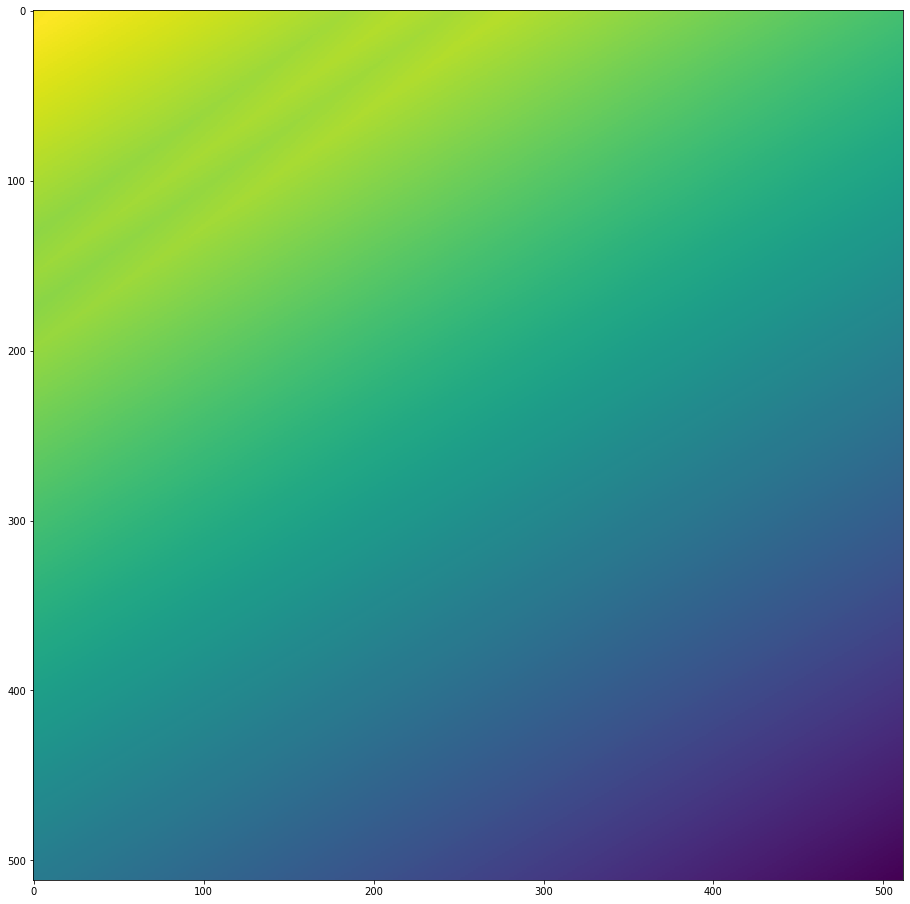

In [40]:
plt.figure(figsize=(16,16))
plt.imshow(noisy_image)

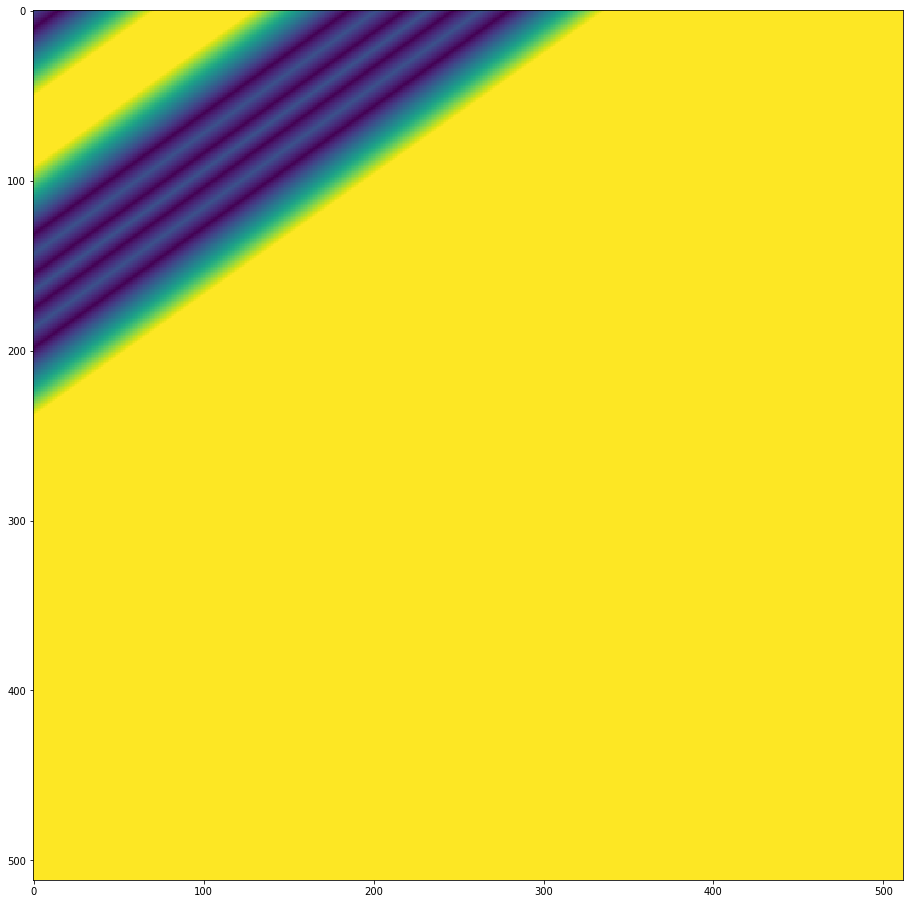

In [41]:
plt.figure(figsize=(16,16))
plt.imshow(distances)